In [1]:
import math
import sys
import numpy as np
from scipy.integrate import simps
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.pyplot as plt
import matplotlib.figure as figure
import matplotlib.patches as mpatches
from matplotlib.ticker import FormatStrFormatter
from six.moves import cPickle as pickle
from scipy.spatial.distance import cosine

In [2]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})


In [2]:
# Helper functions
def unpickle_data(pickle_file):
    """
    Unpickles the data from a pickle file
    """
    f = open(pickle_file, 'rb')
    return pickle.load(f)

def populate_data_dict(data_dict, key, pickle_file):
    """
    Given a key populates a dictionary
    """
    data_dict[key] = unpickle_data(pickle_file)
    
    
def populate_k_shot_acc_dict(data_dict, key, k_shot_dict):
    num_runs = data_dict[key]['mean'].shape[0]
    k_shot_dict[key] = []
    for run in range(num_runs):
        key_acc = data_dict[key]['mean'][run]
        num_batches = key_acc.shape[1]
        num_tasks = key_acc.shape[0]
        k_shot_acc = np.zeros([num_batches], dtype=np.float32)
        for i in range(num_batches):
            acc = 0.0
            for j in range(num_tasks):
                acc += key_acc[j,i,j]
            k_shot_acc[i] = acc/ num_tasks
        
        k_shot_dict[key].append(k_shot_acc)
        
    k_shot_dict[key] = np.array(k_shot_dict[key])

def populate_k_shot_acc_dict_with_varying_batches(data_dict, key, k_shot_dict):
    num_runs = data_dict[key]['mean'].shape[0]
    k_shot_dict[key] = []
    for run in range(num_runs):
        key_acc = data_dict[key]['mean'][run]
        num_tasks = key_acc.shape[0]
      
        batches_per_task = []
        for i in range(num_tasks):
            batches_per_task.append(np.max(np.nonzero(np.sum(key_acc[i], axis=1))))

      
        batches_per_task = np.array(batches_per_task) + 1
        max_batches = np.max(batches_per_task)
        k_shot_acc = np.zeros([max_batches], dtype=np.float32)
    
        for i in range(max_batches):
            acc = 0.0
            task_count_with_this_batch = 0
            for j in range(num_tasks):
                if i < batches_per_task[j]: 
                    acc += key_acc[j,i,j]
                    task_count_with_this_batch += 1
                else:
                    acc += key_acc[j,batches_per_task[j]-1,j]
            k_shot_acc[i] = acc/ num_tasks
        
        
        k_shot_dict[key].append(k_shot_acc)
    
    k_shot_dict[key] = np.array(k_shot_dict[key])
    
    return batches_per_task    


def compute_fgt(acc, key):
    num_tasks = acc.shape[0] 
    last_batch_dim = acc.shape[1] - 1 
    fgt_msr = np.zeros([num_tasks-1]) 
    worst_case_fgt = np.zeros([num_tasks-1]) 
    for i in range(num_tasks):
        if i == 0:
            pass
        else:
            wst_fgt_i = []
            fgt_i = 0.0
            for j in range(i):
                if key == 'GEM' or key == 'ICARL':
                    fgt_per_task = np.amax(acc[:i,j]) - acc[i,j]
                else:
                    fgt_per_task = np.amax(acc[:i,last_batch_dim,j]) - acc[i,last_batch_dim,j]
                        
                fgt_i += fgt_per_task
                wst_fgt_i.append(fgt_per_task)
            fgt_msr[i-1] = fgt_i/ (j+1)
            wst_fgt_i = np.array(wst_fgt_i)
            worst_case_fgt[i-1] = np.max(wst_fgt_i)
                
    return fgt_msr, worst_case_fgt  


def compute_fgt_with_varying_batches(data_dict, batches_per_task):
    fgt_msr = dict()
    for key in data_dict:
        acc = data_dict[key]
        num_tasks = acc.shape[0] 
        last_batch_acc_for_all_tasks = np.zeros([num_tasks, num_tasks])
        
        
        for i in range(num_tasks):
            last_batch_acc_for_all_tasks[i] = acc[i][batches_per_task[i]-1]
        
        fgt_msr[key] = np.zeros([num_tasks-1]) 
        for i in range(num_tasks):
            if i == 0:
                pass
            else:
                fgt_i = 0.0
                for j in range(i):
                    fgt_i += (np.amax(last_batch_acc_for_all_tasks[:i,j]) - last_batch_acc_for_all_tasks[i,j])
                fgt_msr[key][i-1] = fgt_i/ (j+1)
                
    return fgt_msr

def average_acc_stats_across_runs(data, key):
    """
    Compute the average accuracy statistics (mean and std) across runs
    """
    num_runs = data.shape[0]
    avg_acc = np.zeros(num_runs)
    for i in range(num_runs):
        if key == 'GEM':
            avg_acc[i] = np.mean(data[i][-1])
        else:
            avg_acc[i] = np.mean(data[i][-1, -1])
        
    return avg_acc.mean()*100, avg_acc.std()*100

def average_fgt_stats_across_runs(data, key):
    """
    Compute the forgetting statistics (mean and std) across runs
    """
    num_runs = data.shape[0]
    fgt = np.zeros(num_runs)
    wst_fgt = np.zeros(num_runs)
    for i in range(num_runs):
        fgt_i, wst_fgt_i = compute_fgt(data[i], key)
        #print('{}, {}'.format(i, fgt_i))
        fgt[i] = fgt_i[-1]
        wst_fgt[i] = wst_fgt_i[-1]
        
    return fgt.mean(), fgt.std(), wst_fgt.mean(), wst_fgt.std()
        

def plot_k_shot_performance_task_view(n, data_dict, keys, plt_name):
    plt.figure(figsize=(14, 7))
    num_windows = len(keys)
    for i, key in enumerate(keys):
        data = data_dict[key]
        num_tasks = data.shape[0]
        plt.subplot(math.ceil((num_windows+1)/2), math.ceil((num_windows+1)/2), (i+1))
        for k in range(n):
            acc = np.zeros([num_tasks])
            for task in range(num_tasks):
                acc[task] = data[task, k, task]
            plt.plot(np.arange(1,num_tasks+1), acc, label='%d-shot'%(k))
        plt.xlabel('Tasks-%s'%(key))
        plt.ylabel('Avg_Acc')
        plt.xticks(np.arange(1, num_tasks+1))
    plt.tight_layout()
    #plt.legend(loc='best')
    plt.legend(loc=6, bbox_to_anchor=(1, 0.5))
    plt.savefig(plt_name)
    
def plot_k_shot_performance_method_view(n, data_dict, plt_name):
    plt.figure(figsize=(14, 7))
    for k in range(n):
        plt.subplot(n//2, n//2, (k+1))
        for i, key in enumerate(data_dict):
            num_tasks = data_dict[key].shape[0]
            acc = np.zeros(num_tasks)
            for task in range(num_tasks):
                acc[task] = data_dict[key][task, k, task]
            plt.plot(np.arange(1,num_tasks+1), acc, label=key)
        plt.xlabel('Tasks(%d-shot)'%(k))
        plt.ylabel('Avg_Acc')
        plt.xticks(np.arange(1, num_tasks+1))
    plt.tight_layout()
    plt.legend(loc='best')
    #plt.savefig(plt_name)    
    

In [3]:
def plot_average_accuracy_along_training_path(data_mean, plot_name=None, is_cifar=False):
    """
    Plot the average accuracy along the training path
    """
    plt.clf()
    K_FOR_CROSS_VAL = 3
    avg_acc_dict = dict()
    for key in data_mean:
        if key == 'ICARL':
            data = data_mean[key]
            num_tasks = data.shape[0] - K_FOR_CROSS_VAL
        else:
            data = data_mean[key]['mean'].mean(0)
            num_tasks = data.shape[0]
        avg_acc = np.zeros(num_tasks)
        for i in range(num_tasks):
            if key == 'MULTI-TASK':
                avg_acc[i] = np.mean(data)
            elif key == 'ICARL':
                avg_acc[i] = np.mean(data[i,:i+1])
            elif key == 'GEM':
                avg_acc[i] = np.mean(data[i,:i+1])
            else:
                avg_acc[i] = np.mean(data[i,-1,:i+1])
        print(key, avg_acc[-1])
        avg_acc_dict[key] = avg_acc

    
    fig = plt.figure(figsize=(8,2.5))
    ax = fig.add_axes([0.15, 0.21, 0.6, 0.75])
    tasks = np.arange(1, num_tasks+1)
    
    colors = {'MULTI-TASK':'-k', 'VAN': 'C0', 'ICARL':'C1', 'EWC': '-m', 'PI': '-b', 'MAS': '-y', 
              'RWALK':'-g', 'PROG-NN':'C5--', 'GEM':'-c', 'A-GEM':'-r', 'MER': 'C6'}
    
        
    for i, key in enumerate(data_mean):
        if key == 'MULTI-TASK':
            continue
        else:
            if key == 'A-GEM':
                ax.plot(tasks, avg_acc_dict[key],'%s'%(colors[key]), marker='^', markersize=7, lw=2, label=key)
            else:
                ax.plot(tasks, avg_acc_dict[key],'%s'%(colors[key]), lw=2, label=key)
                
    line, =  ax.plot(tasks, avg_acc_dict['MULTI-TASK'],'%s'%(colors['MULTI-TASK']), lw=2, label='MULTI-TASK')
    line.set_dashes([2, 2, 10, 2])
        
    if is_cifar:
        ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.2)
    
    ax.set_xlabel('Tasks', size=20)
    ax.set_ylabel('Avg Accuracy', size=20)
    plt.xticks(tasks)
    plt.grid()

    
    if plot_name is not None:
        plt.savefig(plot_name)
    else:
        plt.show()

In [4]:
def get_zero_shot_perf(data_mean_ohot, data_mean_je):
    """
    Plot the zero-shot performance against the number of tasks
    """
    zero_shot_ohot_perf = dict()
    zero_shot_je_perf = dict()
    
    for key in data_mean_ohot:
        if key == 'MULTI-TASK' or key == 'GEM':
            continue
        
        data_ohot = data_mean_ohot[key]['mean'].mean(0)
        data_je = data_mean_je[key]['mean'].mean(0)
        num_tasks = data_ohot.shape[0] 
        
        zst_ohot_perf = np.zeros(num_tasks)
        zst_je_perf = np.zeros(num_tasks)
        
        #if (data_ohot.shape[0] != num_tasks) or (data_je.shape[0] != num_tasks):
        #    continue
            
        for i in range(num_tasks):
            zst_ohot_perf[i] = data_ohot[i,0,i]
            zst_je_perf[i] = data_je[i,0,i]
            
        zero_shot_ohot_perf[key] = zst_ohot_perf
        zero_shot_je_perf[key] = zst_je_perf
    
    return zero_shot_ohot_perf, zero_shot_je_perf
        

In [5]:
def bar_plot_k_shot_performance(data_dict, shot, is_cifar=False, plt_name=None):
    num_tasks = data_dict['VAN'].shape[0]
    ind = np.arange(1, num_tasks+1) # the x locations for the groups
    width = 0.15 # the width of the bars
    colors = ['r', 'g', 'b', 'c', 'y']
    plt.clf()
    for col_ind, key in enumerate(data_dict):
        acc = np.zeros([num_tasks])
        for task in range(num_tasks):
            acc[task] = data_dict[key][task,shot,task]
        p1 = plt.bar(ind+width*col_ind, acc, width, color='%s'%(colors[col_ind]), bottom=0, label=key)
    
    plt.xticks(np.arange(1, num_tasks+1)) # add loads of ticks

    plt.gca().margins(x=0)
    plt.gcf().canvas.draw()
    tl = plt.gca().get_xticklabels()
    maxsize = max([t.get_window_extent().width for t in tl])
    m = 0.5 # inch margin
    s = maxsize/plt.gcf().dpi*num_tasks+10*m
    margin = m/plt.gcf().get_size_inches()[0]

    plt.gcf().subplots_adjust(left=margin, right=1.-margin)
    plt.gcf().set_size_inches(s, plt.gcf().get_size_inches()[1])
    
    if is_cifar:
        plt.title('%d-Shot Performance'%(shot*5))
    else:
        plt.title('%d-Shot Performance'%(shot))
    plt.legend(loc=6, bbox_to_anchor=(1, 0.8))
    plt.xlabel('Tasks')
    plt.ylabel('Avg_Acc')    
    #plt.show()
    plt.savefig(plt_name)
    

# PERMUTE MNIST

In [37]:
a_gem_pickle = 'path_to_pickle_file_generated_after_training'

NUM_RUNS = 5
MODELS = [ 'A-GEM']

In [38]:
data_mean = dict()
populate_data_dict(data_mean, 'A-GEM', a_gem_pickle)


avg_k_shot_acc = dict()

populate_k_shot_acc_dict(data_mean, 'A-GEM', avg_k_shot_acc)

('MAS', 0.6985364556312561)
('VAN', 0.47952938079833984)
('MULTI-TASK', 0.9537960290908813)
('PROG-NN', 0.9354565143585205)
('EWC', 0.6834882497787476)
('A-GEM', 0.8911787867546082)
('RWALK', 0.857968270778656)
('GEM', 0.8958470588235294)


<Figure size 432x288 with 0 Axes>

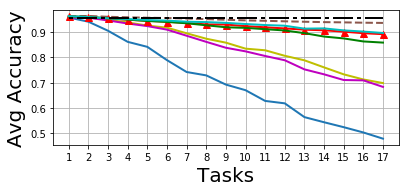

In [13]:
plot_average_accuracy_along_training_path(data_mean, 'iclr_plots/mnist_average_accuracy.pdf')

### Average Accuracy and Forgetting Measure

In [39]:
for key in data_mean:
    if key == 'MULTI-TASK':
        print('{}: {}'.format(key, np.mean(data_mean[key]['mean'][-1])))
    else:
        acc_mean, acc_std = average_acc_stats_across_runs(data_mean[key]['mean'], key)
        fgt_mean, fgt_std, wst_fgt_mean, wst_fgt_std = average_fgt_stats_across_runs(data_mean[key]['mean'], key)
        print('{}=> Acc: {} (+-{}), Fgt: {} (+-{}), Wst Fgt: {} (+-{})'.format(key, acc_mean, 
                                                                               acc_std, fgt_mean, 
                                                                               fgt_std, wst_fgt_mean, 
                                                                               wst_fgt_std))

MAS=> Acc: 69.8536467552 (+-0.934640017162), Fgt: 0.268572501838 (+-0.0100729938001), Wst Fgt: 0.587360012531 (+-0.027087299643)
VAN=> Acc: 47.9529416561 (+-1.317261874), Fgt: 0.510611252487 (+-0.0139219331308), Wst Fgt: 0.779999995232 (+-0.0271953681577)
MULTI-TASK: 0.953796029091
PROG-NN=> Acc: 93.5456466675 (+-0.0672649044055), Fgt: 0.0 (+-0.0), Wst Fgt: 0.0 (+-0.0)
EWC=> Acc: 68.3488249779 (+-0.688293326267), Fgt: 0.288316249475 (+-0.00747878974325), Wst Fgt: 0.578699982166 (+-0.0360688897624)
A-GEM=> Acc: 89.1178810596 (+-0.145538700981), Fgt: 0.0695875033736 (+-0.00146231043289), Wst Fgt: 0.13083999157 (+-0.00925085520745)
RWALK=> Acc: 85.7968246937 (+-0.568200764609), Fgt: 0.0820575013757 (+-0.00677982812048), Wst Fgt: 0.160260009766 (+-0.0298994666151)
GEM=> Acc: 90.2967058824 (+-0.149668884831), Fgt: 0.05532875 (+-0.00235690010925), Wst Fgt: 0.09684 (+-0.00717791055949)


### LCA Measure

In [9]:
num_iters = 55000/ 10
num_batches = []
for iters in range(num_iters):
    if (iters < 10) or (iters < 100 and iters % 10 == 0) or (iters % 100 == 0):
        num_batches.append(iters)
num_batches.append(num_iters)
gem_avg_k_shot = np.array([ 0.09812353,  0.1610647 ,  0.17345884,  0.20008238,  0.19457644,
        0.23791176,  0.26005882,  0.27361766,  0.30264702,  0.32512945,
        0.32201171])

BATCHES_WE_CARE = 10
num_runs = avg_k_shot_acc['VAN'].shape[0]
area_trapz = dict()

area_trapz['A-GEM'] = np.zeros([num_runs, BATCHES_WE_CARE+1])


for run in range(num_runs):
    for measure_upto in range(1, BATCHES_WE_CARE+2):
        batches_upto = num_batches[:measure_upto]
        if measure_upto == 1:
           
            area_trapz['A-GEM'][run][measure_upto-1] = avg_k_shot_acc['A-GEM'][run][0]
        else:
            # Using trapezoidal rule
            max_acc = np.ones_like(batches_upto)
            max_area_trapz = np.trapz(max_acc, batches_upto)
            
            area_trapz['A-GEM'][run][measure_upto-1] = np.trapz(avg_k_shot_acc['A-GEM'][run][:measure_upto], batches_upto)/ max_area_trapz
            
print('LCA_10 classification models:')
for key in area_trapz:
    if key == 'GEM':
        print('{}: {})'.format(key, area_trapz[key][10]))
    else:
        lca_10 = area_trapz[key][:, 10]
        print('{}: {} (+-{})'.format(key, lca_10.mean(), lca_10.std()))

LCA_10 classification models:
MAS: 0.294706057012 (+-0.00389778462622)
VAN: 0.26160264805 (+-0.00670447014861)
PROG-NN: 0.197896528393 (+-0.00618755975804)
EWC: 0.276040763855 (+-0.00317074618471)
A-GEM: 0.291115294695 (+-0.00459682817637)
RWALK: 0.316155999303 (+-0.00566788402049)
GEM: 0.233861469)


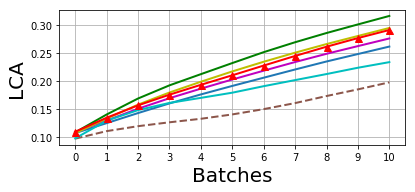

In [11]:
batches_we_care = np.arange(BATCHES_WE_CARE+1)
fig = plt.figure(figsize=(8, 2.5))
ax = fig.add_axes([0.15, 0.21, 0.6, 0.75])


ax.plot(batches_we_care, np.mean(area_trapz['A-GEM'], axis=0),'-r', marker='^', markersize=7, lw=2, label='A-GEM')


ax.set_xlabel('Batches', size=20)
ax.set_ylabel('LCA', size=20)
plt.xticks(batches_we_care)
#ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.2)
#ax.legend(loc='best', borderaxespad=0.2)
plt.grid()
#plt.show()
plt.savefig('iclr_plots/fam_mnist.pdf')